In [6]:
import torch
import torch.optim as optim
import torch.distributions as dist
import matplotlib.pyplot as plt
import math

from tqdm import tqdm

# Set a random seed for reproducibility
torch.manual_seed(0)

# Black-Box Variational Inference

In [7]:
def generate_data(mu, tau, N):
  x = torch.linspace(-10, 10, N)
  # Insert your code here
  sigma = 1 / torch.sqrt(torch.tensor(tau))   # precision τ = 1/σ²
  D = torch.normal(mu, sigma, size=(N,))

  return D

mu = 1
tau = 0.5
N= 100
data= generate_data(mu, tau, N)

print(f"Generated {N} data points.")
print(f"Data mean: {data.mean():.4f}")
print(f"Data std dev: {data.std():.4f}")
print(f"Data shape: {data.shape}")

Generated 100 data points.
Data mean: 1.0525
Data std dev: 1.4561
Data shape: torch.Size([100])


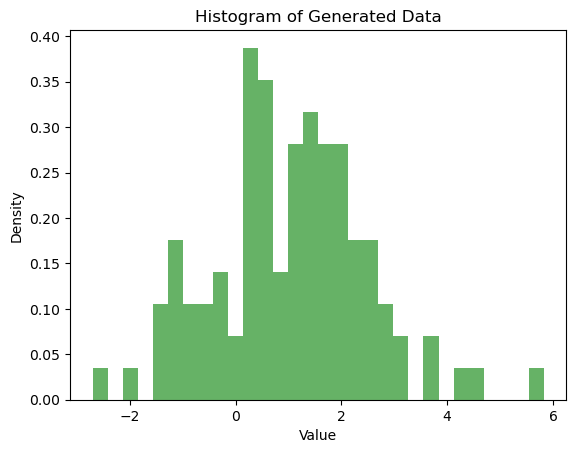

In [8]:
# Visualize the data
plt.hist(data.numpy(), bins=30, density=True, alpha=0.6, color='g')
plt.title("Histogram of Generated Data")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

## 🧮 Part 1: Analytic Posterior Computation

The posterior $p(μ∣D)=N(\mu_N,σ^2_N)$ has parameters:
$$\frac{1}{\sigma_N^2} = \frac{1}{\sigma_{\text{prior}}^2} + \frac{N}{\sigma_{\text{data}}^2}$$
and
$$\mu_N = \sigma_N^2 \left( \frac{\mu_{\text{prior}}}{\sigma_{\text{prior}}^2} + \frac{\sum_{i=1}^N x_i}{\sigma_{\text{data}}^2} \right) $$


In [9]:
# --- Compute Analytic Posterior ---

# 1. Calculate Precisions (1 / variance)
# Precision of the prior N(0, 1)
prior_precision = 1.0 / PRIOR_VAR

# Precision contributed by the N data points
# Each point has variance DATA_VAR, so N points contribute N / DATA_VAR
data_precision = N / DATA_VAR

# 2. Posterior precision is the sum
posterior_precision = prior_precision + data_precision

# 3. Convert back to variance and standard deviation
posterior_var = 1.0 / posterior_precision
posterior_std = math.sqrt(posterior_var)

# 4. Calculate Posterior Mean
# It's a precision-weighted sum of means
# (prior_precision * PRIOR_MEAN) + (data_precision * data.mean())
# which is equivalent to:
# (PRIOR_MEAN / PRIOR_VAR) + (data.sum() / DATA_VAR)

posterior_mean = posterior_var * ( (PRIOR_MEAN / PRIOR_VAR) + (data.sum() / DATA_VAR) )

print("--- Ground Truth Posterior ---")
print(f"Posterior Mean (μ_N):   {posterior_mean.item():.4f}")
print(f"Posterior Std Dev (σ_N): {posterior_std:.4f}")
print(f"Posterior Var (σ_N^2):   {posterior_var:.4f}")

NameError: name 'PRIOR_VAR' is not defined

## Part 2: BBVI Implementation - SGD vs Adagrad

### Define model components

In [ ]:
def sample_q_mu(m, s, K):
    q_dist = dist.Normal(m, s)
    return q_dist.sample((K,))

def log_prior(mu):
    log_prior_dist = dist.Normal(PRIOR_MEAN, math.sqrt(PRIOR_VAR))
    return log_prior_dist.log_prob(mu)

def log_likelihood(mu, data):
    # We need to sum the log-likelihoods for all N data points
    # We use broadcasting: mu is [K] or [1], data is [N]
    # We want log_prob to be [K, N], then sum over N (dim=1)
    return dist.Normal(mu.unsqueeze(1), math.sqrt(DATA_VAR)).log_prob(data).sum(dim=-1)

def log_joint(mu, data):
    return log_prior(mu) + log_likelihood(mu, data)

def log_q_mu(mu, m, s):
    q_dist = dist.Normal(m, s)
    return q_dist.log_prob(mu)

def score_function_mu(mu, m, s):
    return (mu - m) / (s ** 2)

def score_function_s(mu, m, s):
    return -1. + ((mu - m) ** 2) / (s ** 2)

### Naive BBVI Implementation
This implementation manually computes the score functions and constructs the surrogate loss as per the log-derivative trick.
It follows the Naive BBVI algorithm, i.e., without Rao-Blackwellization and Control Variates, called Algorithm 1 in the BBVI paper.

In [ ]:
def bbvi_naive_loss(m, log_s, data, K):
    """
    Calculates the surrogate loss for BBVI.
    Minimizing this loss is equivalent to maximizing the ELBO.
    Following Algorithm 1 in the BBVI paper, we:
    1. Sample K values from the variational distribution q(mu | lambda)
    2. Evaluate it on log p(x, mu | sigma^2) - log q(mu) and score-function of q(mu).
    3. Average over the samples to get a Monte Carlo estimate of the gradient of the ELBO.
    """
    s = torch.exp(log_s)    # Optimize log_s than s directly since log_s is unconstrained

    # 1. Sample mu ~ q(mu | lambda)
    mu_samples = sample_q_mu(m, s, K)

    # 2. Compute log q(mu)
    log_q_vals = log_q_mu(mu_samples, m, s)

    # 3. Compute log p(D, mu)
    log_joint_vals = log_joint(mu_samples, data)

    # 4. Compute the learning signal f(mu)
    f = log_joint_vals - log_q_vals

    # 5. Compute the score functions
    score_m = score_function_mu(mu_samples, m, s)
    score_s = score_function_s(mu_samples, m, s) # Actually score for log_s

    # 6. Compute the surrogate loss
    # We detach 'f' to treat it as a constant, as per the log-derivative trick
    elbo = f.mean()    # MC estimate of ELBO
    grad_m_ELBO_est = (score_m * f).mean()
    grad_s_ELBO_est = (score_s * f).mean()

    return grad_m_ELBO_est, grad_s_ELBO_est, elbo

#### Run SGD Optimization

In [ ]:
# Variational parameters
m_sgd = torch.tensor(0.0, requires_grad=False)
log_s_sgd = torch.tensor(0.0, requires_grad=False) # s=1.0

# SGD parameters
lr_sgd = 1e-7         # A small learning rate (Setting large will make it crash!)
K = 10                # Number of MC samples per step
T = 20000             # Number of iterations

# History for plotting
m_history_sgd = []
s_history_sgd = []
elbo_history_sgd = []

print(f"Running SGD with lr={lr_sgd}...")
pbar = tqdm(range(T))
for t in pbar:
    grad_m_ELBO_est, grad_s_ELBO_est, elbo = bbvi_naive_loss(m_sgd, log_s_sgd, data, K)

    # SGD step
    m_sgd += lr_sgd * grad_m_ELBO_est
    log_s_sgd += lr_sgd * grad_s_ELBO_est

    # Store results
    m_history_sgd.append(m_sgd.item())
    s_history_sgd.append(torch.exp(log_s_sgd).item())
    elbo_history_sgd.append(elbo.item())

    if (t + 1) % 500 == 0:
        pbar.set_description(f"ELBO: {elbo.item():.2f},"
                         f" m: {m_sgd.item():.4f},"
                         f" s: {torch.exp(log_s_sgd).item():.4f}")

print("SGD optimization finished.")

#### Visualize SGD results

In [ ]:
# Plot ELBO

plt.figure(figsize=(12, 8))
plt.plot(elbo_history_sgd, label="ELBO")
plt.title(f"SGD: ELBO (lr={lr_sgd})")
plt.xlabel("Iteration")
plt.ylabel("m")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(14, 6))

# Plot for m
plt.subplot(1, 2, 1)
plt.plot(m_history_sgd, label="SGD Estimate")
plt.axhline(posterior_mean.item(), color='r', linestyle='--', label="Ground Truth $\mu_N$")
plt.title(f"SGD: Convergence of Mean (m) (lr={lr_sgd})")
plt.xlabel("Iteration")
plt.ylabel("m")
plt.legend()

# Plot for s
plt.subplot(1, 2, 2)
plt.plot(s_history_sgd, label="SGD Estimate")
plt.axhline(posterior_std, color='r', linestyle='--', label="Ground Truth $\sigma_N$")
plt.title(f"SGD: Convergence of Std Dev (s) (lr={lr_sgd})")
plt.xlabel("Iteration")
plt.ylabel("s")
plt.legend()

plt.tight_layout()
plt.show()

### Naive BBVI loss using Automatic Differentiation
The same as above, but we leverage PyTorch's autograd to compute gradients automatically.
Note that we do not need to compute the score functions manually here.

In [ ]:
def bbvi_naive_loss_auto_diff(m, log_s, data, K):
    """
    Calculates the surrogate loss for BBVI.
    Minimizing this loss is equivalent to maximizing the ELBO.
    Here we sample K values from the variational distribution q(mu | lambda), evaluate it on both the log joint and log variational and average over the samples to get a Monte Carlo estimate of the loss.
    """
    s = torch.exp(log_s)

    # 1. Sample mu ~ q(mu | lambda)
    mu_samples = sample_q_mu(m, s, K)

    # 2. Compute log q(mu)
    log_q_vals = log_q_mu(mu_samples, m, s)

    # 3. Compute log p(D, mu)
    log_joint_vals = log_joint(mu_samples, data)

    # 4. Compute the learning signal f(mu)
    f = log_joint_vals - log_q_vals

    # 5. Compute the surrogate loss
    # We detach 'f' to treat it as a constant, as per the log-derivative trick
    elbo = f.detach().mean()    # MC estimate of ELBO

    loss = -(log_q_vals * f.detach()).mean()

    return loss, elbo

*#### Optimization with SGD

In [ ]:
# Variational parameters
m_sgd = torch.tensor(0.0, requires_grad=True)
log_s_sgd = torch.tensor(0.0, requires_grad=True) # s=1.0

# SGD parameters
lr_sgd = 1e-5      # A small learning rate (Setting large will make it crash!)
K = 10                # Number of MC samples per step
T = 20000             # Number of iterations

optimizer_sgd = optim.SGD([m_sgd, log_s_sgd], lr=lr_sgd)

# History for plotting
m_history_sgd = []
s_history_sgd = []
elbo_history_sgd = []

print(f"Running SGD with lr={lr_sgd}...")
pbar = tqdm(range(T))
for t in pbar:
    optimizer_sgd.zero_grad()
    loss, elbo = bbvi_naive_loss_auto_diff(m_sgd, log_s_sgd, data, K)
    loss.backward()
    optimizer_sgd.step()

    # Store results
    m_history_sgd.append(m_sgd.item())
    s_history_sgd.append(torch.exp(log_s_sgd).item())
    elbo_history_sgd.append(elbo.item())

    if (t + 1) % 500 == 0:
        pbar.set_description(f"ELBO: {elbo.item():.2f},"
                         f" m: {m_sgd.item():.4f},"
                         f" s: {torch.exp(log_s_sgd).item():.4f}")

print("SGD optimization finished.")

#### Visualize SGD auto-diff results

In [ ]:
# Plot ELBO

plt.figure(figsize=(12, 8))
plt.plot(elbo_history_sgd, label="ELBO")
plt.title(f"SGD: ELBO (lr={lr_sgd})")
plt.xlabel("Iteration")
plt.ylabel("m")
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(14, 6))

# Plot for m
plt.subplot(1, 2, 1)
plt.plot(m_history_sgd, label="SGD Estimate")
plt.axhline(posterior_mean.item(), color='r', linestyle='--', label="Ground Truth $\mu_N$")
plt.title(f"SGD: Convergence of Mean (m) (lr={lr_sgd})")
plt.xlabel("Iteration")
plt.ylabel("m")
plt.legend()

# Plot for s
plt.subplot(1, 2, 2)
plt.plot(s_history_sgd, label="SGD Estimate")
plt.axhline(posterior_std, color='r', linestyle='--', label="Ground Truth $\sigma_N$")
plt.title(f"SGD: Convergence of Std Dev (s) (lr={lr_sgd})")
plt.xlabel("Iteration")
plt.ylabel("s")
plt.legend()

plt.tight_layout()
plt.show()

### Adagrad Optimization

In [ ]:
# Reset variational parameters
m_adagrad = torch.tensor(0.0, requires_grad=True)
log_s_adagrad = torch.tensor(0.0, requires_grad=True) # s=1.0

# Adagrad parameters
lr_adagrad = 0.1     # A MUCH larger learning rate!
K = 10               # Same number of MC samples
T = 20000           # Same number of iterations

optimizer_adagrad = optim.Adagrad([m_adagrad, log_s_adagrad], lr=lr_adagrad)

# History for plotting
m_history_adagrad = []
s_history_adagrad = []
elbo_history_adagrad = []

# History for Q3
eff_lr_m_history = []
eff_lr_s_history = []

print(f"Running Adagrad with lr={lr_adagrad}...")
pbar = tqdm(range(T))
for t in pbar:
    optimizer_adagrad.zero_grad()
    loss, elbo = bbvi_naive_loss_auto_diff(m_adagrad, log_s_adagrad, data, K)
    loss.backward()
    optimizer_adagrad.step()

    # Store results
    m_history_adagrad.append(m_adagrad.item())
    s_history_adagrad.append(torch.exp(log_s_adagrad).item())
    elbo_history_adagrad.append(elbo.item())

    # --- For Q3: Store effective learning rates ---
    # Access the optimizer's internal state 'sum' (which is G)
    # Add optimizer's epsilon (default 1e-10) for numerical stability
    g_m_sq_sum = optimizer_adagrad.state[m_adagrad]['sum'].item()
    g_s_sq_sum = optimizer_adagrad.state[log_s_adagrad]['sum'].item()

    eff_lr_m = lr_adagrad / (1e-10 + math.sqrt(g_m_sq_sum))
    eff_lr_s = lr_adagrad / (1e-10 + math.sqrt(g_s_sq_sum))

    eff_lr_m_history.append(eff_lr_m)
    eff_lr_s_history.append(eff_lr_s)
    # ---

    if (t + 1) % 500 == 0:
        pbar.set_description(f"ELBO: {elbo.item():.2f},"
                            f" m: {m_adagrad.item():.4f},"
                            f" s: {torch.exp(log_s_adagrad).item():.4f}")

print("Adagrad optimization finished.")

#### Visualize Adagrad results

In [ ]:
# Plot ELBO
print(f"Final ELBO (Adagrad): {elbo_history_adagrad[-1]:.4f}")
plt.figure(figsize=(12, 8))
plt.plot(elbo_history_adagrad, label="ELBO")
plt.title(f"Adagrad: ELBO (lr={lr_adagrad})")
plt.xlabel("Iteration")
plt.ylabel("m")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(14, 6))

# Plot for m
plt.subplot(1, 2, 1)
plt.plot(m_history_adagrad, label="Adagrad Estimate")
plt.axhline(posterior_mean.item(), color='r', linestyle='--', label="Ground Truth $\mu_N$")
plt.title(f"Adagrad: Convergence of Mean (m) (lr={lr_adagrad})")
plt.xlabel("Iteration")
plt.ylabel("m")
plt.legend()

# Plot for s
plt.subplot(1, 2, 2)
plt.plot(s_history_adagrad, label="Adagrad Estimate")
plt.axhline(posterior_std, color='r', linestyle='--', label="Ground Truth $\sigma_N$")
plt.title(f"Adagrad: Convergence of Std Dev (s) (lr={lr_adagrad})")
plt.xlabel("Iteration")
plt.ylabel("s")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# --- Plot Effective Learning Rates ---
iterations_to_plot = slice(0, 100)
plt.figure(figsize=(12, 5))
plt.plot(eff_lr_m_history[iterations_to_plot], label="Effective LR for m")
plt.plot(eff_lr_s_history[iterations_to_plot], label="Effective LR for $\log s$")
plt.title("Adagrad's Effective Learning Rate Over Time")
plt.xlabel("Iteration")
plt.ylabel("Effective Learning Rate")
plt.legend()
plt.show()

## Part 3: Control Variates

### Define BBVI loss with control variate

In [ ]:
def bbvi_loss_with_control_variate(m, log_s, data, K, optimizer):
    """
    Calculates the BBVI loss with control variates.
    Following the from Algorithm 2 in the BBVI paper, we:
    1. Sample K values from the variational distribution q(mu | lambda)
    2. Evaluate it on log p(x, mu | sigma^2) - log q(mu) to compute the learning signal f
    3. Compute the score functions analytically
    4. Compute optimal baselines for variance reduction
    5. Compute the gradient estimates using the control variates
    6. Apply gradients manually using the provided optimizer
    """
    s = torch.exp(log_s)
    q_dist = dist.Normal(m, s)
    mu_samples = q_dist.sample((K,))

    # 1. Compute f (Learning Signal)
    log_q = q_dist.log_prob(mu_samples)
    log_joint_val = log_joint(mu_samples, data)
    f = (log_joint_val - log_q).detach()
    elbo = (log_joint_val - log_q).mean().item()  # MC estimate of ELBO

    # 2. Compute Scores (Analytic)
    score_m = (mu_samples - m) / s**2
    score_s = -1 + ((mu_samples - m)**2 / s**2) # Score for log_s

    # 3. Compute Optimal Baselines
    a_m = (f * score_m**2).mean() / (score_m**2).mean()
    a_s = (f * score_s**2).mean() / (score_s**2).mean()

    # 4. Compute Gradients (The "Black Box" Gradient Estimator)
    grad_m = (score_m * (f - a_m)).mean()
    grad_s = (score_s * (f - a_s)).mean()

    # 5. Apply Gradients Manually
    # We need to negate them because we are maximizing, but optimizers minimize
    optimizer.zero_grad()
    m.grad = -grad_m
    log_s.grad = -grad_s
    optimizer.step()

    return a_m.item(), a_s.item(), elbo

### Run SGD with Control Variate

In [ ]:
# --- SGD and AdaGrad with Control Variate ---

# Reset parameters
m_cv = torch.tensor(0.0, requires_grad=True)
log_s_cv = torch.tensor(0.0, requires_grad=True)

# Use a learning rate that failed/struggled in Part 2
# (You can try 0.001 or even 0.01)
lr_sgd = 0.001
optimizer_cv = optim.SGD([m_cv, log_s_cv], lr=lr_sgd)
#lr_adagrad = 1.0
#optimizer_cv = optim.Adam([m_cv, log_s_cv], lr=lr_sgd)
T = 2000

m_history_cv = []
s_history_cv = []
elbo_history_cv = []

print(f"Running SGD with Control Variate (lr={lr_sgd})...")
pbar = tqdm(range(T))
optimizer_cv.zero_grad()
for t in pbar:

    # Calculate loss using the *current* baseline
    loss, current_batch_mean, elbo = bbvi_loss_with_control_variate(m_cv, log_s_cv, data, K=10, optimizer=optimizer_cv)

    m_history_cv.append(m_cv.item())
    s_history_cv.append(torch.exp(log_s_cv).item())
    elbo_history_cv.append(elbo)

    if (t + 1) % 500 == 0:
        pbar.set_description(f"ELBO: {elbo:.2f},"
                             f"m: {m_cv.item():.4f},"
                            f" s: {torch.exp(log_s_cv).item():.4f}")

print("Done.")

### Plot Control Variate results

In [ ]:
# Plot ELBO
plt.figure(figsize=(12, 8))
plt.plot(elbo_history_cv, label="ELBO")
plt.title(f"SGD + Control Variate: ELBO (lr={lr_sgd})")
plt.xlabel("Iteration")
plt.ylabel("m")
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(14, 6))
# Plot for m
plt.subplot(1, 2, 1)
plt.plot(m_history_cv, label="SGD + CV Estimate")
plt.axhline(posterior_mean.item(), color='r', linestyle='--', label="Ground Truth $\mu_N$")
plt.title(f"SGD + Control Variate: Convergence of Mean (m) (lr={lr_sgd})")
plt.xlabel("Iteration")
plt.ylabel("m")
plt.legend()

# Plot for s
plt.subplot(1, 2, 2)
plt.plot(s_history_cv, label="SGD + CV Estimate")
plt.axhline(posterior_std, color='r', linestyle='--', label="Ground Truth $\sigma_N$")
plt.title(f"SGD + Control Variate: Convergence of Std Dev (s) (lr={lr_sgd})")
plt.xlabel("Iteration")
plt.ylabel("s")
plt.legend()

plt.tight_layout()
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/85/xt8_stpd459d9zhcnm21ykc40000gn/T/ipykernel_14314/221677377.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(posterior_mean.item(), color='r', linestyle='--', label="Ground Truth $\mu_N$")
/var/folders/85/xt8_stpd459d9zhcnm21ykc40000gn/T/ipykernel_14314/221677377.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(posterior_std, color='r', linestyle='--', label="Ground Truth $\sigma_N$")
/var/folders/85/xt8_stpd459d9zhcnm21ykc40000gn/T/ipykernel_14314/221677377.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(posterior_mean.item(), color='r', linestyle='--', label="Ground Truth $\mu_N$")
/var/folders/85/xt8_stpd459d9zhcnm21ykc40000gn/T/ipykernel_14314/221677377.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(poste

NameError: name 'plt' is not defined